In [105]:
import numpy as np
from numpy.random import choice, random
import matplotlib.pyplot as plt
from typing import Tuple, Optional

In [106]:
class GridWorldCell:
    """Base class for all cells in the grid world."""
    def __init__(self, x: int, y: int, char: str = ' ', color: Tuple[int, int, int] = (0, 0, 0), reward: int = 0):
        self.x: int = x
        self.y: int = y
        self._char: str = char
        self._color: Tuple[int, int, int] = color
        self._reward: int = reward
        self.value: float = 0.0
        self.policy: Optional[str] = None

    @property
    def char(self) -> str:
        return self._char

    @char.setter
    def char(self, value: str):
        self._char = value

    @property
    def color(self) -> Tuple[int, int, int]:
        return self._color

    @color.setter
    def color(self, value: Tuple[int, int, int]):
        self._color = value

    @property
    def reward(self) -> int:
        return self._reward

    @reward.setter
    def reward(self, value: int):
        self._reward = value

    def __str__(self) -> str:
        description_str = (
            f'Type: {self.__class__.__name__} ({self.char} - {self.color})\n'
            f'Position: ({self.x}, {self.y})\n'
            f'Reward: {self.reward}\n'
            f'Policy: {self.policy}\n'
            f'Value: {self.value}\n'
        )
        return description_str


class TreeAppleCell(GridWorldCell):
    """Represents a tree that can have an apple."""

    def __init__(self, x: int, y: int, with_apple: bool = True):
        super().__init__(x, y)
        self.with_apple: bool = with_apple

    @property
    def char(self) -> str:
        return 'A' if self.with_apple else 'T'

    @property
    def color(self) -> Tuple[int, int, int]:
        return (45, 135, 87) if self.with_apple else (34, 102, 66)

    @property
    def reward(self) -> int:
        return 1 if self.with_apple else 0

    def __str__(self) -> str:
        description_str = super().__str__()
        description_str += f'Apple: {self.with_apple}\n'
        return description_str


class WallCell(GridWorldCell):
    """Represents a wall cell that cannot be traversed."""
    def __init__(self, x: int, y: int):
        super().__init__(x=x, y=y, char='W', color=(157, 161, 159))


class GrassCell(GridWorldCell):
    """Represents a grass cell that can be traversed."""
    def __init__(self, x: int, y: int):
        super().__init__(x=x, y=y, char=' ', color=(169, 245, 173))


class RespawnCell(GridWorldCell):
    """Represents a respawn point for agents."""
    def __init__(self, x: int, y: int):
        super().__init__(x=x, y=y, char='P', color=(229, 237, 116))


class PrincipalRespawnCell(RespawnCell):
    """Represents the principal respawn point."""
    def __init__(self, x: int, y: int):
        super().__init__(x=x, y=y)
        self.char = 'Q'
        self.color = (223, 235, 54)


In [107]:
class HarvestWorld():
    def __init__(self, ascii_map, regrowth_probs):
        self.timestep = 0
        self.ASCII_MAP = ascii_map
        self.regrowth_probs = regrowth_probs
        self.ascii_matrix = np.array([list(row) for row in ascii_map.strip().split('\n')])
        self.object_map = self.create_object_map()
        self.appletree_positions = [(cell.x, cell.y) for cell in self.object_map.flatten()
                                    if isinstance(cell, TreeAppleCell)]
 
        
        
    def create_object_map(self):
        object_map = np.empty(self.ascii_matrix.shape, dtype=object)
        for i in range(self.ascii_matrix.shape[0]):
            for j in range(self.ascii_matrix.shape[1]):
                cell_char = self.ascii_matrix[i, j]
                if cell_char == 'W':
                    object_map[i, j] = WallCell(i, j)
                elif cell_char in {'A', 'T'}:
                    with_apple = cell_char == 'A'
                    object_map[i, j] = TreeAppleCell(i, j, with_apple)
                elif cell_char == 'P':
                    object_map[i, j] = RespawnCell(i, j)
                elif cell_char == 'Q':
                    object_map[i, j] = PrincipalRespawnCell(i, j)
                else:
                    object_map[i, j] = GrassCell(i, j)
                    
        return object_map
    
    
    def get_apple_positions(self):
        return [(x,y) for x,y in self.appletree_positions if self.object_map[x,y].with_apple]

    
    def plot_map(self):
        plt.clf()
        
        plt.imshow([[c.color for c in row] for row in self.object_map])
        
        apple_positions = self.get_apple_positions()
        
        if apple_positions:
            x_coords, y_coords = zip(*apple_positions)
            plt.scatter(y_coords, x_coords, color='red')

        
        plt.show()
        
        
    def advance_timestep(self):
        self.timestep += 1
        
        apple_positions = self.get_apple_positions()
        for apple_tree in self.appletree_positions:
            if apple_tree not in apple_positions:
                regrowth = choice(self.regrowth_probs)
                if random() < regrowth:
                    self.object_map[apple_tree].with_apple = True
        
        return self.timestep

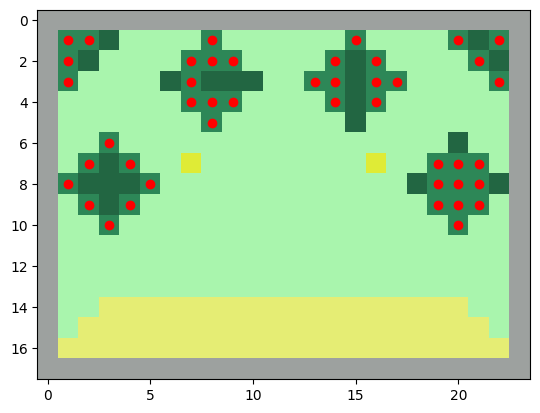

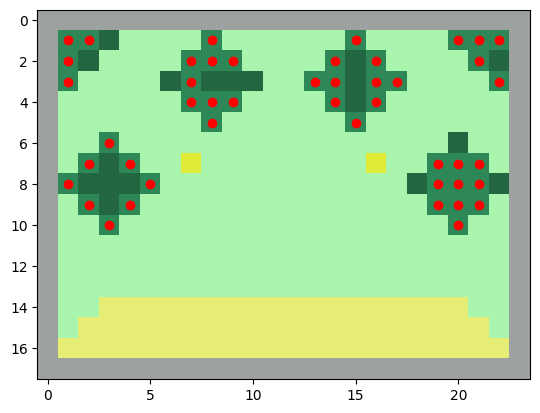

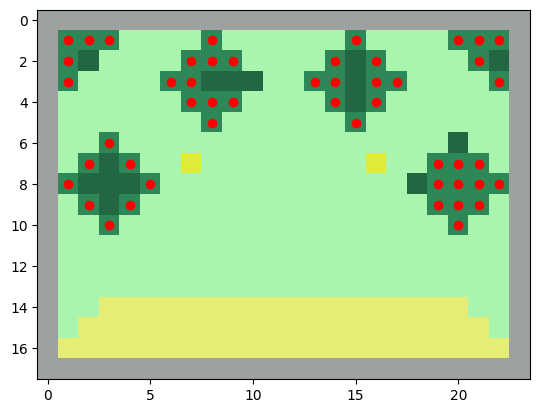

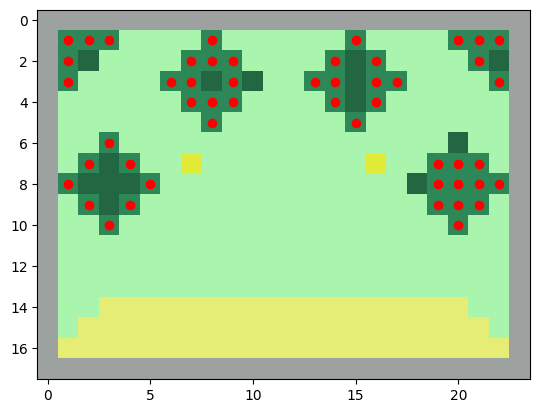

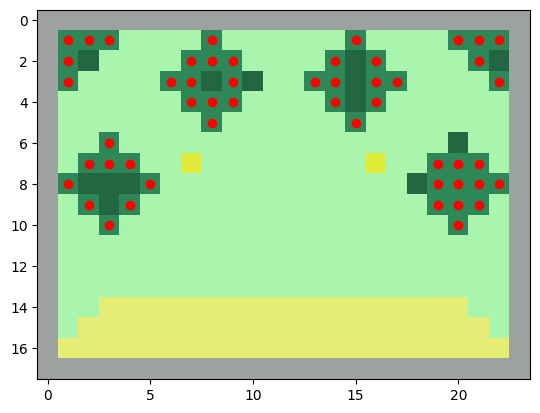

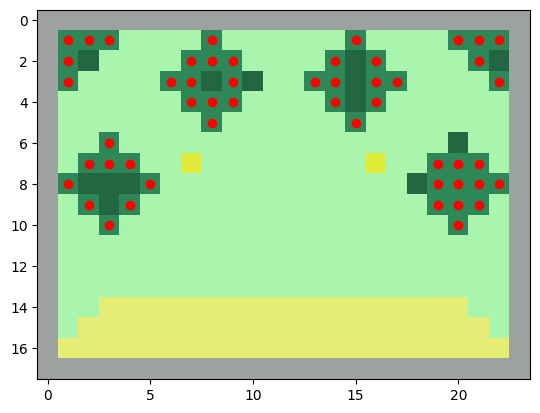

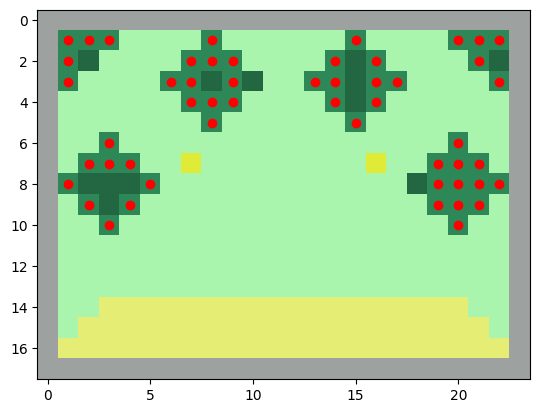

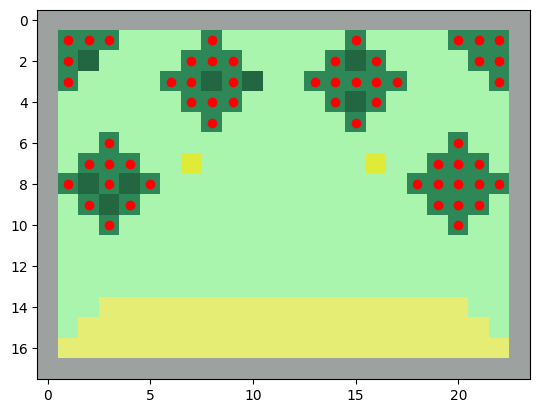

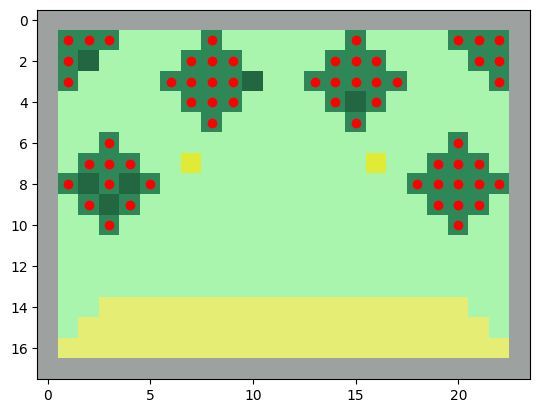

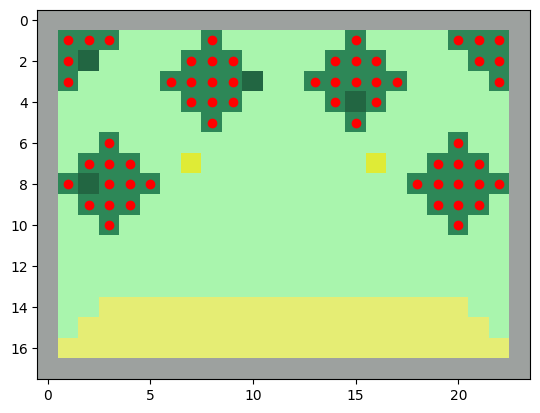

In [108]:
ASCII_MAP = """
WWWWWWWWWWWWWWWWWWWWWWWW
WAAT    A      T    ATAW
WAT    AAA    ATA    ATW
WT    TTTTT  AATAA    AW
W      AAA    ATA      W
W       A      T       W
W  A                T  W
W ATA  Q        Q  AAA W
WATTTA            TAAATW
W ATA              AAA W
W  A                T  W
W                      W
W                      W
W                      W
W  PPPPPPPPPPPPPPPPPP  W
W PPPPPPPPPPPPPPPPPPPP W
WPPPPPPPPPPPPPPPPPPPPPPW
WWWWWWWWWWWWWWWWWWWWWWWW
"""

harvest_world = HarvestWorld(ASCII_MAP, 
                             regrowth_probs=[0.0, 0.05, 0.125, 0.4])

for _ in range(10):
    harvest_world.advance_timestep()
    harvest_world.plot_map()